# Cauchy example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [74]:
# auxiliary functions
def kl(lq,lp,randq,B=1000):
    sample=randq(B)
    return np.mean(lq(sample)-lp(sample))

In [24]:
# target definition
def lp(x): return -np.log(1+x**2)-np.log(np.pi)
def randp(size): return np.random.standard_cauchy(size)

In [19]:
# gaussian variational approximation
def lq(x,mu,logsigma):
    sigma=np.exp(logsigma)
    return -0.5*((x-mu)/sigma)**2-0.5*np.log(2*np.pi*sigma**2)

In [33]:
# gradients

def mu_gradient(B,mu,lsigma,lp,randp,divergence='rev-kl'):
    if divergence=='rev-kl':
        sample=mu+np.exp(lsigma)*np.random.randn(B) #~N(mu,sigma^2)
        return np.mean((lq(sample,mu,lsigma)-lp(sample))*(sample-mu)*np.exp(-2*lsigma))
    return

def ls_gradient(B,mu,lsigma,lp,randp,divergence='rev-kl'):
    if divergence=='rev-kl':
        sample=mu+np.exp(lsigma)*np.random.randn(B) #~N(mu,sigma^2)
        return np.mean((lq(sample,mu,lsigma)-lp(sample))*(np.exp(-2*lsigma)*(sample-mu)**2-1.))
    return

In [48]:
# optimization wrapper
def gaussianVI(lp,randp,divergence='rev-kl',B=1000,max_iters=1001,lr_mu=1e-2,lr_lsigma=1e-2):
    # initial values
    mus=np.zeros(max_iters+1)
    mus[0]=np.random.randn() # initialize mu at a draw from std normal (cause 0 is probably the opt, let's make it harder)
    lsigmas=np.zeros(max_iters+1)
    lsigmas[0]=np.random.randn() # ditto

    # optimize
    print('Initial μ: '+str(mus[0]))
    print('Initial σ: '+str(np.exp(lsigmas[0])))
    print()
    print('Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient')
    for t in range(max_iters):
        # calculate gradients
        grad_mu=mu_gradient(B,mus[t],lsigmas[t],lp,randp,divergence)
        grad_lsigma=ls_gradient(B,mus[t],lsigmas[t],lp,randp,divergence)
    
        # take step
        mus[t+1]=mus[t]-lr_mu*grad_mu
        lsigmas[t+1]=lsigmas[t]-lr_lsigma*grad_lsigma
    
        # do printout
        if t%(max_iters//10)==0: print('  '+str(t)+'   | '+str(mus[t+1])+'   | '+str(np.exp(lsigmas[t+1]))+'   | '+str(grad_mu)+'  | '+str(grad_lsigma))
    # end for
    
    print()
    print('Final μ: '+str(mus[-1]))
    print('Final σ: '+str(np.exp(lsigmas[-1])))
    return mus,lsigmas

In [62]:
# optimization

# settings
np.random.seed(520)
max_iters=10001
lr_mu=1e0
lr_lsigma=1e0
B=10000 # monte carlo sample size for gradient estimation
divergence='rev-kl'

mus,lsigmas=gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | -0.6020109351065399   | 1.874266201881889   | -0.8089341133284977  | -0.9085391091811823
  1000   | 0.002268626329861253   | 1.6737239746139163   | -0.0005669384574940196  | 0.034441935546407364
  2000   | 0.003697496149563093   | 1.6152627720549169   | 0.0012451711191226373  | 0.026590778120960175
  3000   | -0.0006644677642236093   | 1.6377949627073267   | 0.0004610499010876156  | 0.007786648771897754
  4000   | -0.005001758881410938   | 1.6183837645638386   | 0.0019343022203284065  | 0.007782013727144913
  5000   | -2.5138116534610157e-05   | 1.6051070845852196   | 0.004971025881887297  | 0.02714965166802337
  6000   | -0.003969436701750453   | 1.6253114826849802   | -0.004158628496192519  | -0.009414177072554828
  7000   | -0.00486743167020746   | 1.686380786755494   | 0.003004470162207507  | -0.024693622801051605
  8000   |

In [72]:
rev_mu=mus[-1]
rev_lsigma=lsigmas[-1]

lq_rev = lambda x : lq(x,rev_mu,rev_lsigma)
randq_rev = lambda B : rev_mu+np.exp(rev_lsigma)*np.random.randn(B)

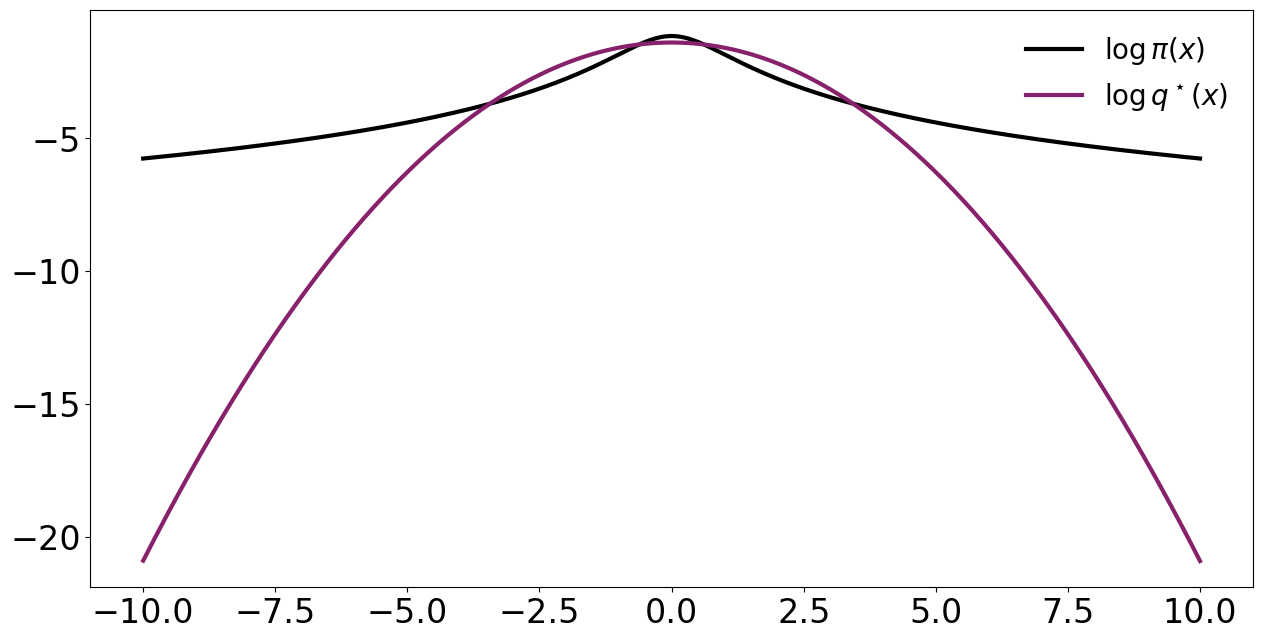

In [69]:
lsx=np.linspace(-10,10,1000)
plt.plot(lsx,lp(lsx),c="black", label=r'$\log\pi(x)$',lw=3)
plt.plot(lsx,lq_rev(lsx),c='#87216BFF', label=r'$\log q^\star(x)$',lw=3)
plt.legend(fontsize='small',frameon=False)

In [86]:
kl(lq_rev,lp,randq_rev,B=10000)

0.18482134149204535